In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, brier_score_loss,
                            classification_report, confusion_matrix, average_precision_score, recall_score)
import joblib

import shap
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")

#  EDA — focused, business-oriented

### load and initial EDA

In [14]:
df = pd.read_csv(r"D:\Data\ML\Decision Tree\HR_comma_sep.csv")
df.shape

(14999, 10)

In [51]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [15]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Target balance

In [18]:
print("Attrition distribuion (count): ")
print(df['left'].value_counts())
print("\nAttrition distribuion (percent): ")
print(df['left'].value_counts(normalize=True).round(3)*100)

Attrition distribuion (count): 
left
0    11428
1     3571
Name: count, dtype: int64

Attrition distribuion (percent): 
left
0    76.2
1    23.8
Name: proportion, dtype: float64


###  Basic numeric stats

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


### Distribution visuals (numeric features)

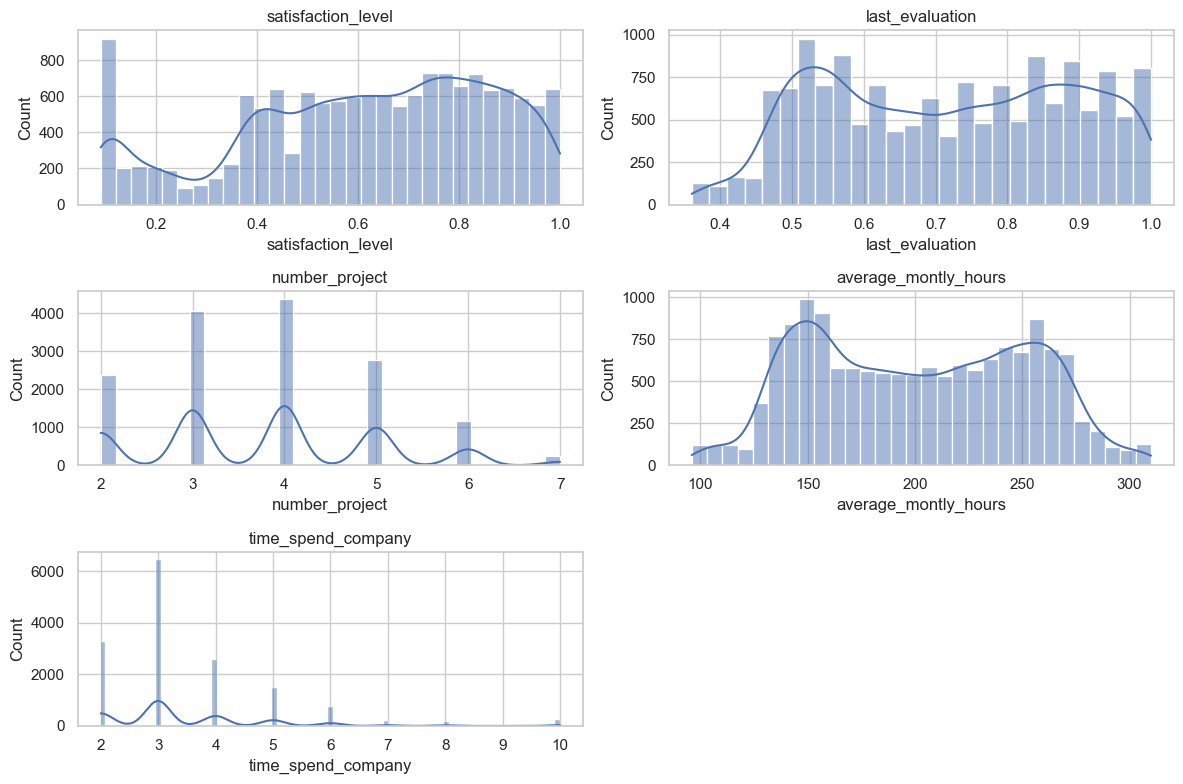

In [24]:
numeric = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

### Dept & salary attrition rates (business insight)

In [29]:
debt = df.groupby('Department')['left'].agg(['count','sum']).sort_values('sum', ascending=False)
debt['leave_rate'] = (debt['sum']/debt['count']).round(3) * 100
display(debt.sort_values('leave_rate', ascending=False))

,count,sum,leave_rate
Department,,,
hr,739,215,29.1
accounting,767,204,26.6
technical,2720,697,25.6
support,2229,555,24.9
sales,4140,1014,24.5
marketing,858,203,23.7
IT,1227,273,22.2
product_mng,902,198,22.0
RandD,787,121,15.4


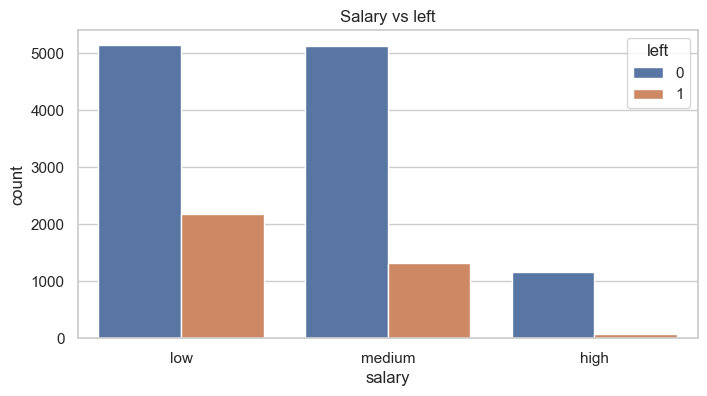

In [42]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='salary', hue='left')
plt.title("Salary vs left")
plt.show()

### correlations among numeric features

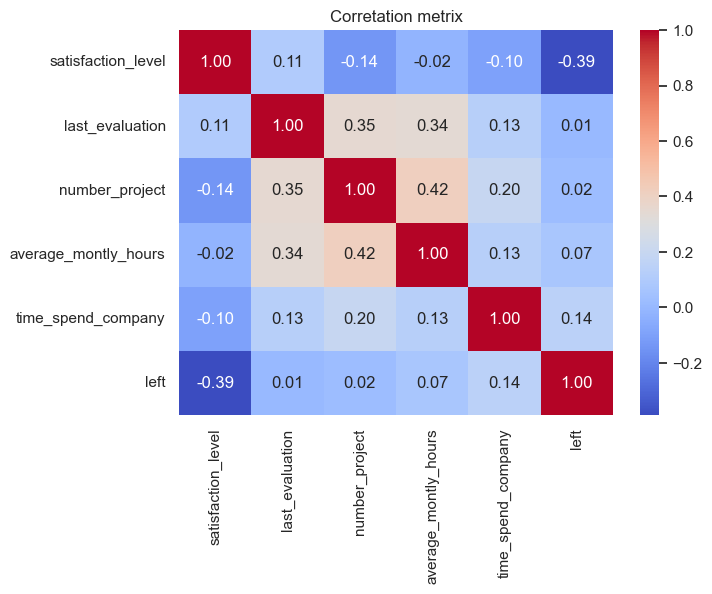

In [45]:
plt.figure(figsize=(7,5))
sns.heatmap(df[numeric + ['left']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Corretation metrix")
plt.show()

# Preprocessing pipeline — encode categories, scale numeric

### define column groups

In [70]:
X = df.drop(columns=['left'])
y = df['left']

cat_ohe = ['Department']         # one-hot
cat_ord = ['salary']             # ordinal (low<medium<high)
num_cols = [c for c in X.columns if c not in cat_ohe + cat_ord]

# Ordinal mapping for salary
salary_categories = [['low', 'medium','high']]

### Preprocessing & pipelines

In [71]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_ohe),
        ('ore', OrdinalEncoder(categories=salary_categories), cat_ord),
        ('num', StandardScaler(), num_cols)
    ], remainder='drop'
)

# Decision Tree classifier with class_weight balancing
clf = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")

# Option A: pipeline without SMOTE
pipe_no_smote = Pipeline([
    ('pre', preprocessor),
    ('clf', clf)
])

# Option B: pipeline with SMOTE (applied to training folds during CV)
pipe_smote = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', clf)
])

#### Choose pipeline for GridSearch

In [62]:
use_smote = False
pipeline = pipe_smote if use_smote else pipe_no_smote

# Quick check: fit preprocessor on small sample to confirm no errors
pipeline.named_steps['pre'] if 'pre' in pipeline.named_steps else pipeline

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Department']),
                                ('ore',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high']]),
                                 ['salary']),
                                ('num', StandardScaler(),
                                 ['satisfaction_level', 'last_evaluation',
                                  'number_project', 'average_montly_hours',
                                  'time_spend_company', 'Work_accident',
                                  'promotion_last_5years'])])

#  Hyperparameter tuning (GridSearchCV) — include pruning parameter search

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

In [69]:
# To get ccp_alpha candidates, we must fit a preliminary tree on training-transformed data
# Fit preprocessor alone and transform X_train
X_train_trans = preprocessor.fit_transform(X_train)

# Temporary tree to get pruning path
temp_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
temp_tree.fit(X_train_trans, y_train)

path = temp_tree.cost_complexity_pruning_path(X_train_trans, y_train)
ccp_alphas = path.ccp_alphas

# sample a manageable set of alphas (exclude 0 and near-max extremes)
alpha_candidates = np.unique(np.quantile(ccp_alphas, np.linspace(0.05, 0.95, 8)))
print("Candidate ccp_alphas:", alpha_candidates)


Candidate ccp_alphas: [3.80511221e-19 1.28457024e-17 9.95123893e-05 1.25277041e-04
 1.94647885e-04 2.91800336e-04 5.17680001e-04 3.87960456e-03]


#### finding best params and CV f1_macro

In [87]:
param_grid = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [3,5,7,9],
    'clf__min_samples_split': [2,5,10,20],
    'clf__min_samples_leaf': [1,2,4],
    'clf__ccp_alpha': list(alpha_candidates)  # will be passed to classifier via pipeline
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best param: ", grid.best_params_)
print("Best CV f1_macro:: ", grid.best_score_)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best param:  {'clf__ccp_alpha': 0.003879604562578472, 'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV f1_macro::  0.9677087706009745


In [74]:
best_pipeline = grid.best_estimator_
best_clf = best_pipeline.named_steps['clf']

# Cross-validation diagnostics & test evaluation

In [75]:
# CV diagnostics and test set evaluation
# cross-validate best_pipeline on the training data to get score distribution
cv_results = cross_validate(
    best_pipeline, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring=['accuracy','f1_macro','roc_auc'], 
    return_train_score=False
)

print("CV (train folds) scores (mean ± std):")
for k in ['test_accuracy','test_f1_macro','test_roc_auc']:
    print(f"{k}: {cv_results[k].mean():.4f} ± {cv_results[k].std():.4f}")

CV (train folds) scores (mean ± std):
test_accuracy: 0.9777 ± 0.0028
test_f1_macro: 0.9694 ± 0.0037
test_roc_auc: 0.9694 ± 0.0024


In [77]:
# Final evaluation on the holdout test set
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:,1] if hasattr(best_pipeline, "predict_proba") else None

print("\nTest set metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision (pos):", precision_score(y_test, y_test_pred))
print("Recall (pos):", recall_score(y_test, y_test_pred))
print("F1 (pos):", f1_score(y_test, y_test_pred))


Test set metrics:
Accuracy: 0.9747474747474747
Precision (pos): 0.9292682926829269
Recall (pos): 0.9678238780694327
F1 (pos): 0.9481542928245541


In [78]:
if y_test_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_test_proba))
    print("PR AUC:", average_precision_score(y_test, y_test_proba))
    print("Brier score:", brier_score_loss(y_test, y_test_proba))

ROC AUC: 0.970329276065339
PR AUC: 0.8883553039369418
Brier score: 0.024130055254799138



Classification report (test):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3769
           1       0.93      0.97      0.95      1181

    accuracy                           0.97      4950
   macro avg       0.96      0.97      0.97      4950
weighted avg       0.98      0.97      0.97      4950



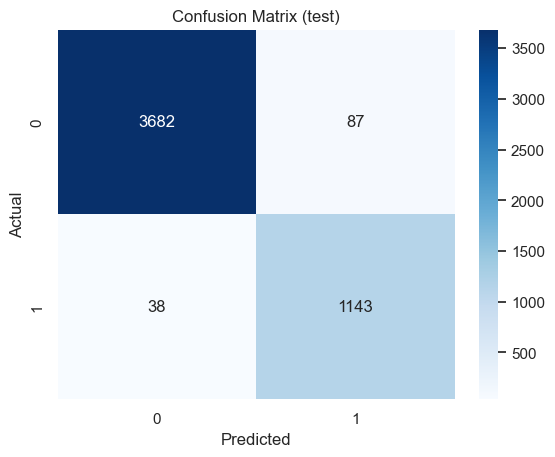

In [79]:
# classification report & confusion matrix
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix (test)")
plt.show()

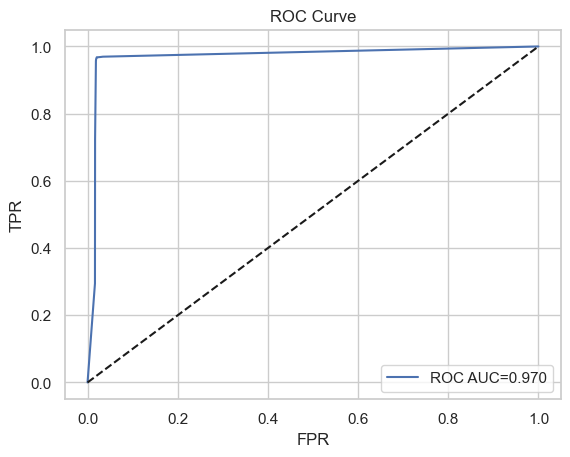

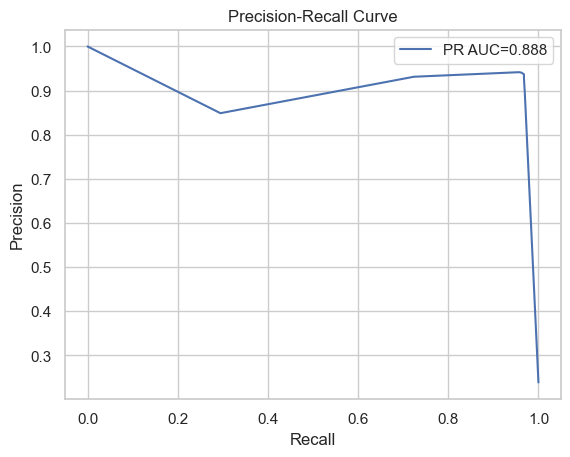

In [80]:
# ROC and PR curves
if y_test_proba is not None:
    fpr, tpr, th = roc_curve(y_test, y_test_proba)
    plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_score(y_test, y_test_proba):.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); 
    plt.ylabel("TPR"); 
    plt.legend(); 
    plt.title("ROC Curve")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
    plt.plot(recall, precision, label=f"PR AUC={average_precision_score(y_test, y_test_proba):.3f}")
    plt.xlabel("Recall"); 
    plt.ylabel("Precision"); 
    plt.title("Precision-Recall Curve")
    plt.legend(); plt.show()

#  Model complexity & pruning 

In [85]:
depths = [3,4,5,6,7,8,9, None]
depth_scores = []
for d in depths:
    tmp_pipeline = Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(max_depth=d, class_weight='balanced', random_state=RANDOM_STATE))
    ])
    sc = cross_val_score(tmp_pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    depth_scores.append((d, sc.mean(), sc.std()))
display(pd.DataFrame(depth_scores, columns=['max_depth', 'mean_f1_macro', 'std']))

,max_depth,mean_f1_macro,std
0,3.0,0.884574,0.014113
1,4.0,0.904028,0.013491
2,5.0,0.918221,0.015130
3,6.0,0.917252,0.011916
4,7.0,0.962508,0.005367
5,8.0,0.966300,0.003194
6,9.0,0.966596,0.006188
7,NaN,0.968824,0.003408


# Explainability: feature importances, rules, SHAP

,feature,Importance
11,satisfaction_level,0.439674
15,time_spend_company,0.306369
12,last_evaluation,0.118497
14,average_montly_hours,0.080914
13,number_project,0.026418
10,salary,0.008639
9,Department_technical,0.006002
7,Department_sales,0.002804
3,Department_hr,0.002559
16,Work_accident,0.001835


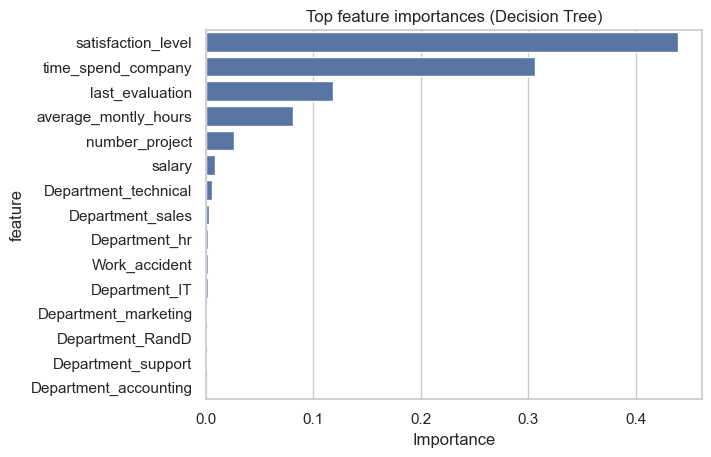

In [96]:
# get feature names after ColumnTransformer
pre = best_pipeline.named_steps['pre']
# Obtain OHE names safely
ohe = pre.named_transformers_['ohe']
ohe_names = ohe.get_feature_names_out(['Department']) if hasattr(ohe, 'get_feature_names_out') else ohe.get_feature_names_out(['Department'])
feature_names = list(ohe_names) + ['salary'] + num_cols

clf = best_pipeline.named_steps['clf']
importance = clf.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'Importance': importance}).sort_values('Importance', ascending=False)
display(feat_imp)
sns.barplot(x='Importance', y='feature',data=feat_imp.head(15))
plt.title("Top feature importances (Decision Tree)")
plt.show()

In [97]:
r= export_text(clf, feature_names=feature_names, max_depth=4)
print(r)

|--- satisfaction_level <= -0.60
|   |--- time_spend_company <= 0.68
|   |   |--- time_spend_company <= -0.69
|   |   |   |--- satisfaction_level <= -1.89
|   |   |   |   |--- last_evaluation <= 1.13
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |--- last_evaluation >  1.13
|   |   |   |   |   |--- class: 0
|   |   |   |--- satisfaction_level >  -1.89
|   |   |   |   |--- last_evaluation <= 1.31
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- last_evaluation >  1.31
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |--- time_spend_company >  -0.69
|   |   |   |--- average_montly_hours <= -1.52
|   |   |   |   |--- class: 0
|   |   |   |--- average_montly_hours >  -1.52
|   |   |   |   |--- last_evaluation <= -1.59
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- last_evaluation >  -1.59
|   |   |   |   |   |--- truncated branch of depth 14
|   |--- time_spend_company >  0.68
|   |   |--- satisfaction_level <= -2.01
|   |

In [99]:
leaf_ids = clf.apply(pre.transform(X_train))  # leaf for each training sample
leaf_df = pd.DataFrame({'leaf': leaf_ids, 'y': y_train.values})
leaf_stats = leaf_df.groupby('leaf')['y'].agg(['count','sum'])
leaf_stats['pos_rate'] = leaf_stats['sum'] / leaf_stats['count']
leaf_stats = leaf_stats.sort_values('count', ascending=False)
display(leaf_stats.head(10))

,count,sum,pos_rate
leaf,,,
291,1893,0,0.000000
47,1010,1006,0.996040
270,788,0,0.000000
505,581,574,0.987952
57,543,543,1.000000
214,437,0,0.000000
396,378,0,0.000000
141,224,0,0.000000
432,222,0,0.000000


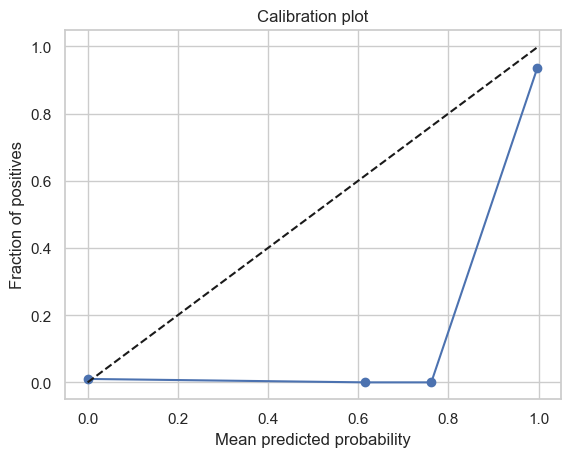

,precision,recall
0,0.238586,1.000000
1,0.899450,0.969517
2,0.912281,0.968671
3,0.929268,0.967824
4,0.930782,0.967824
5,0.936885,0.967824
6,0.940447,0.962743
7,0.941079,0.960203
8,0.941667,0.956816
9,0.931373,0.723963


In [101]:
# Cell 7 - calibration and thresholding
# calibration check
from sklearn.calibration import calibration_curve
if y_test_proba is not None:
    prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration plot")
    plt.show()

# threshold tuning: compute recall and precision at many thresholds
probs = y_test_proba
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
# choose threshold for target recall (e.g., ensure recall >= 0.8)
target_recall = 0.8
idx = next((i for i,r in enumerate(recalls[::-1]) if r >= target_recall), None)
# simpler: show table of thresholds -> precision/recall
pr_df = pd.DataFrame({'precision': precisions, 'recall': recalls})
display(pr_df.head(20))


In [111]:
# Cell 8 - save the full pipeline
joblib.dump(best_pipeline, "hr_attrition_decision_tree_pipeline.joblib")
# load later with:
# loaded = joblib.load("hr_attrition_decision_tree_pipeline.joblib")


['hr_attrition_decision_tree_pipeline.joblib']